In [29]:
from functools import reduce
import pandas as pd
import numpy as np
from scipy.sparse.csgraph import shortest_path, connected_components
from scipy.sparse import dok_matrix, csr_matrix
from collections import Counter
# import networkx as nx
import matplotlib.pyplot as plt
# from networkx.drawing.nx_agraph import graphviz_layout
import altair as alt

from simulation.constants import *
from simulation.google_cloud import GoogleCloud

In [3]:
gcloud = GoogleCloud()

<AxesSubplot:xlabel='datetime'>

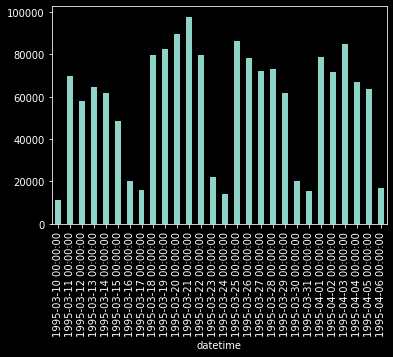

In [31]:
df = pd.read_csv(DATA_FOLDER / "bt_symmetric.csv")
df = df[(df["rssi"] >= -90) & (df["rssi"] < 0) & (df["user_b"] >= 0)].rename(columns={"# timestamp": "datetime", "user_a": "source", "user_b": "destination"}).reset_index(drop=True)
df = df[["datetime", "source", "destination"]]
df["datetime"] = pd.to_datetime(df["datetime"], unit="s", origin="1995-03-10") 
display(df.resample("D", on="datetime")["source"].count().plot.bar())
df.to_csv(DATA_FOLDER / "copenhagen_interactions.csv", index=False)
# .resample("D").count()

In [7]:
cdf = pd.read_csv(DATA_FOLDER / "copenhagen_interactions.csv", parse_dates=["datetime"])
five_minutes = [snapshot for _, snapshot in cdf.resample("5T", on="datetime")]
cdf_0 = cdf[cdf["datetime"] == cdf["datetime"].iloc[0]]

In [85]:
groupdf =  pd.read_csv(DATA_FOLDER / "copenhagen_groups.csv", parse_dates=["datetime"])
groupdf["group"] = groupdf["group"].apply(lambda x: eval(x)).str.len()
groupdf["datetime"] = (groupdf["datetime"] -pd.Timedelta("11D")).dt.day - 1
# groupdf.drop_duplicates("datetime")
df = groupdf.groupby(["datetime", "group"])["duration"].count().reset_index(level=0).groupby("group").mean()[["duration"]].reset_index()
alt.Chart(df).mark_bar().encode(
    x=alt.X("group:Q", title="Amount of participants"),
    y=alt.Y("duration:Q", title="Average amount of meetings per day")
).save("avg_participants_per_meeting.html")


In [93]:
aggdf =  pd.read_csv(DATA_FOLDER / "copenhagen_agg.csv", parse_dates=["datetime"])
aggdf["datetime"] = (aggdf["datetime"] -pd.Timedelta("11D")).dt.day - 1
df = aggdf.groupby(['datetime',"duration"]).count()["source"].reset_index(level=0).groupby("duration").mean().drop(columns=["datetime"]).reset_index()
alt.Chart(df).mark_bar().encode(
    x=alt.X("source:Q", title="Meeting duration", scale=alt.Scale(domain=(30,1300),clamp=True)),
    y=alt.Y("duration:Q", title="Average amount of meetings per day")
).save("avg_daily_meetings_per_duration.html")

In [ ]:
cdf = pd.read_csv("random_test.csv", names=["datetime", "source", "destination"])
cdf["datetime"] = pd.to_datetime("03/10/1995") + ((cdf["datetime"]*5).astype(str) + "m").apply(pd.Timedelta)

In [ ]:
def show_graph(G, labels=False, partition=False):
    plt.figure(1, figsize=(8,8))
    pos = graphviz_layout(G, prog="neato")
#     pos = nx.spring_layout(G)
    if partition:
        pass
#         cmap = cm.get_cmap("cool", max(partition.values()) + 1)
#         nx.draw(G, 
#                 pos,
#                 node_size=1500,
#                 cmap=cmap, 
#                 node_color=list(partition.values()),
#                 with_labels=True)
    else:
        nx.draw(G, pos, node_size=40, vmin=0.0, vmax=1.0, with_labels=True)
        try:
            if labels:
                nx.draw_networkx_edge_labels(G, pos, edge_labels={t[:2]: int(t[2]["hops"]) for t in G.edges.data()})
        except KeyError:
            pass
    plt.show()
#     plt.savefig(f"{'-'.join(list(map(str,shortest_path)))}.png")

## hops

In [ ]:
fm = five_minutes[0]
row, col = fm[["source", "destination"]].values.T
data = [1] * len(row)
size = max(np.append(row,col)) + 1
#     singletons = len([x for x in range(size) if x not in np.append(row,col)])
graph = csr_matrix((data*2, (np.append(row,col), np.append(col,row))), shape=(size, size))
_, labels = connected_components(graph, directed=False)
# #     cc -= singletons
# {k:v for k, v in Counter(labels).items() if v > 2}
group_indices = [k for k, v in Counter(labels).items() if v > 2]
group_participants = [i for i, e in enumerate(labels) if e in group_indices]
# group_participants
sp = shortest_path(graph, directed=False, method="D")
sp[sp == np.inf] = 0.
df = pd.DataFrame({"hops": dict(dok_matrix(np.triu(sp)))}).rename_axis(["source", "destination"]).reset_index()
df
# df["datetime"] = fm["datetime"].iloc[0]
# df["is_group"] = df["source"].isin(group_participants)

In [ ]:
group_indices

In [ ]:
cdf_0[cdf_0["destination"] == 12]

adding hops should take around 7-8 mins

In [ ]:
%%time
hops=[]
for fm in five_minutes:
    row, col = fm[["source", "destination"]].values.T
    data = [1] * len(row)
    size = max(np.append(row,col)) + 1
#     singletons = len([x for x in range(size) if x not in np.append(row,col)])
    graph = csr_matrix((data*2, (np.append(row,col), np.append(col,row))), shape=(size, size))
    _, labels = connected_components(graph, directed=False)
#     cc -= singletons
    group_indices = [k for k, v in Counter(labels).items() if v > 2]
    group_participants = [i for i, e in enumerate(labels) if e in group_indices]
    sp = shortest_path(graph, directed=False, method="D")
    sp[sp == np.inf] = 0.
    df = pd.DataFrame({"hops": dict(dok_matrix(np.triu(sp)))}).rename_axis(["source", "destination"]).reset_index()
    df["datetime"] = fm["datetime"].iloc[0]
    df["is_group"] = df["source"].isin(group_participants)
    hops.append(df)

cdf = pd.concat(hops)

In [ ]:
cdf_0 = cdf[cdf["datetime"] == cdf["datetime"].iloc[0]]
cdf_0

In [ ]:
cdfset = set([["source", "destination"]].to_records(index=False).tolist())

grouping by timestamp should take around 3 mins

In [ ]:
cdf["meeting_nodes"] = cdf[["source", "destination"]].apply(
    lambda x: tuple(sorted(x)), axis=1
)
cdf = cdf.sort_values(["meeting_nodes", "datetime"]).reset_index(drop=True)
cdf["meeting_id"] = (cdf["datetime"].diff() != pd.Timedelta("5m")).cumsum()
cdf = (
    cdf.groupby(["meeting_id", "meeting_nodes"]) # , "hops", "is_group"])
    .agg(
        **{
            "duration": pd.NamedAgg(column="datetime", aggfunc=lambda x: x.count() * 5),
            "datetime": pd.NamedAgg(column="datetime", aggfunc="min"),
        }
    )
    .reset_index()
)
cdf[["source", "destination"]] = pd.DataFrame(cdf["meeting_nodes"].tolist())
cdf = cdf.drop(columns=["meeting_nodes", "meeting_id"])
cdf


show sample result hops

In [ ]:
G = nx.from_pandas_edgelist(
    cdf[cdf["datetime"] == pd.to_datetime("03/27/2021 14:55:00")],
    target="destination",
    edge_attr=True,
)
show_graph(G, labels=True)


In [ ]:
cdf.drop(columns=["hops", "is_group"]).sort_values("datetime").to_csv(DATA_FOLDER / "copenhagen_interactions.csv", index=False)

In [ ]:
raw = pd.read_csv(DATA_FOLDER / "copenhagen_interactions.csv")
agg = pd.read_csv(DATA_FOLDER / "copenhagen_interactions_agg.csv")

In [ ]:
agg_0 = agg[agg["datetime"] == agg.loc[0, "datetime"]].sort_values("destination").reset_index(drop=True)

In [ ]:
aggset = set(agg_0[["source", "destination"]].to_records(index=False).tolist())
rawset = set(raw_0[["destination", "source"]].to_records(index=False).tolist())

In [ ]:
gcloud.upload(DATA_FOLDER / "copenhagen_hops.csv", bucket_name="simulation_datasets")

In [ ]:
pd.read_csv(DATA_FOLDER / "copenhagen_hops.csv", nrows=10)

## groups

In [ ]:
def group_sets(a, b):
    for i, x in enumerate(a):
        if len(x & b) > 0:
            a[i] = x | b
            return a
    else:
        return a + [b]

In [ ]:
%%time
cdf["meeting_nodes"] = cdf[["source", "destination"]].apply(lambda x: tuple(sorted(x)), axis=1)
cdf = cdf.sort_values(["meeting_nodes", "datetime"]).reset_index(drop=True)
cdf["meeting_id"] = (cdf["datetime"].diff() !=  pd.Timedelta('5m')).cumsum()
cdf = (cdf.groupby(["meeting_id","meeting_nodes"])
            .agg(**{
                "duration": pd.NamedAgg(column='datetime', aggfunc=lambda x: x.count() * 5), 
                "datetime": pd.NamedAgg(column='datetime', aggfunc='min'),
            }).reset_index()
           )
cdf[["source", "destination"]] = pd.DataFrame(cdf["meeting_nodes"].tolist())
# cdf = cdf.drop(columns=["meeting_nodes", "meeting_id"])
cdf

In [ ]:
grouped = cdf.groupby(["datetime", "duration"])["meeting_nodes"].apply(list)
group_meetings = (grouped.apply(lambda x: [set(i) for i in x])
        .apply(lambda x: list(reduce(group_sets, x, [])))
        .explode()
        .to_frame("group")
        .reset_index()
)

In [ ]:
group_meetings.to_csv(DATA_FOLDER / "copenhagen_groups_2.csv", index=False)

## Results

In [ ]:
lax_count = []
strict_count = []
for ii, g in df.groupby(["datetime", "duration"]):
    G = from_pandas_edgelist(g, target="destination")
    l = list(connected_components(G))
    lax_count += [len(i) for i in l]
    x = [i for i in l if len(i) > 2]
    y = [i for i in l if len(i) == 2]
    for s in x:
        if (len(p:= g[g["source"].isin(s) | g["destination"].isin(s)])) == len(s):
            strict_count.append(len(s))
    strict_count += [2] * len(y)
cr_lax = pd.Series(dict(Counter(lax_count))).sort_values(ascending=False)
cr_strict = pd.Series(dict(Counter(strict_count))).sort_values(ascending=False)